# GPR

In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor                 
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared,Matern
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (RationalQuadratic,Exponentiation)
from sklearn.gaussian_process.kernels import CompoundKernel
import matplotlib.pyplot as plt

In [2]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Head_acceleration]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# alpha
- float or ndarray of shape (n_samples,), default=1e-10
- Value added to the diagonal of the kernel matrix during fitting. This can prevent a potential numerical issue during fitting, by ensuring that the calculated values form a positive definite matrix. It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations. Note that this is different from using a WhiteKernel. If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level. Allowing to specify the noise level directly as a parameter is mainly for convenience and for consistency with Ridge.

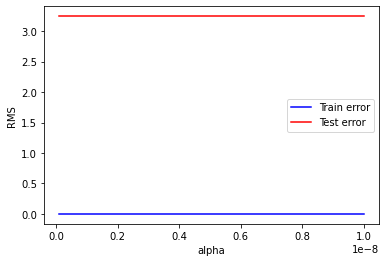

In [21]:
n_estimators = np.logspace(-10, -8, 20, endpoint=True)
train_results = []
test_results = []
kernel=ConstantKernel()* RationalQuadratic(alpha=0.1, length_scale=1)
for eta in n_estimators:
    model = GaussianProcessRegressor(kernel=kernel, alpha=eta)

    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    ax=mean_squared_error(y_train, train_pred,squared=False)
    train_results.append(ax)
    y_pred = model.predict(x_test)
    ax=mean_squared_error(y_test, y_pred,squared=False)
    test_results.append(ax)
line1, = plt.plot(n_estimators, train_results, 'b', label="Train error")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test error")
plt.legend()
plt.ylabel('RMS')
plt.xlabel('alpha')
plt.show()

# n_restarts_optimizer
- The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.

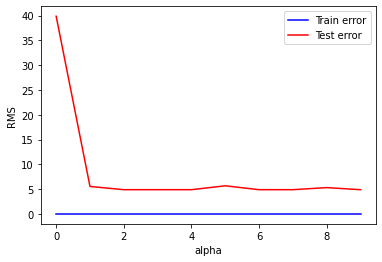

In [22]:
n_estimators = np.arange(0, 10, 1)
train_results = []
test_results = []
kernel=ConstantKernel()* RationalQuadratic(alpha=0.1, length_scale=1)
for eta in n_estimators:
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=eta,optimizer='fmin_l_bfgs_b')

    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    ax=mean_squared_error(y_train, train_pred,squared=False)
    train_results.append(ax)
    y_pred = model.predict(x_test)
    ax=mean_squared_error(y_test, y_pred,squared=False)
    test_results.append(ax)
line1, = plt.plot(n_estimators, train_results, 'b', label="Train error")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test error")
plt.legend()
plt.ylabel('RMS')
plt.xlabel('alpha')
plt.show()

# Random Search

In [17]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Head]

In [18]:
# ker = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-05, 2)) * RationalQuadratic(alpha=0.1, length_scale=1,length_scale_bounds=(1e-05, 25), alpha_bounds=(1e-05,25),)
# ker = ConstantKernel(1.0) * RBF(1.0)
# ker = DotProduct() + WhiteKernel(noise_level=0.5)
# ker=Exponentiation(RBF(), exponent=2)
ker=Exponentiation(RationalQuadratic(), exponent=2)+WhiteKernel(noise_level=0.5)
# ker=ConstantKernel()*RationalQuadratic(length_scale=24,alpha=1)
# ker= CompoundKernel([WhiteKernel(noise_level=3.0), RBF(length_scale=2.0)])
param_grid = {"kernel": [ker],
              "alpha": [1e-10,2,5],
              "optimizer": ["fmin_l_bfgs_b"],
              "n_restarts_optimizer": [1, 2, 3,4],
              "normalize_y": [False, True],
              "random_state": [0]}

In [19]:

rf = GaussianProcessRegressor()
reg = GridSearchCV(rf,param_grid = param_grid ,cv = 10, return_train_score=True,scoring="neg_root_mean_squared_error", verbose=2, n_jobs = -1)
reg.fit(X,y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.7s finished


GridSearchCV(cv=10, estimator=GaussianProcessRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 2, 5],
                         'kernel': [RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5)],
                         'n_restarts_optimizer': [1, 2, 3, 4],
                         'normalize_y': [False, True],
                         'optimizer': ['fmin_l_bfgs_b'], 'random_state': [0]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [20]:
reg.best_params_

{'alpha': 1e-10,
 'kernel': RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
 'n_restarts_optimizer': 4,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [21]:
reg.best_estimator_

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
                         n_restarts_optimizer=4, normalize_y=True,
                         random_state=0)

In [22]:
#Chest
# mod=GaussianProcessRegressor(alpha=1.1, copy_X_train=False,
#                          kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(copy_X_train=False,
#                          kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1),
#                          n_restarts_optimizer=3, random_state=0)
# mod=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=20),
#                          n_restarts_optimizer=2, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2,
#                          n_restarts_optimizer=1, random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=3, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=4, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=RBF(length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0,alpha=5)
# mod=GaussianProcessRegressor(kernel=RBF(length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(alpha=2, kernel=RBF(length_scale=1) ** 2,
#                          n_restarts_optimizer=2, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=1, length_scale=24),
#                          n_restarts_optimizer=1, random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=24) ** 2,
#                          n_restarts_optimizer=4, random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=24) ** 2,
#                          n_restarts_optimizer=4, random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 +0.5* WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=4, normalize_y=True,
#                          random_state=0)
# head acc
# mod=GaussianProcessRegressor(alpha=2,
#                          kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
# mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
#                          n_restarts_optimizer=1, normalize_y=True,
#                          random_state=0)
mod=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1) ** 2 + WhiteKernel(noise_level=0.5),
                         n_restarts_optimizer=4, normalize_y=True,
                         random_state=0)

In [23]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [24]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')


<Figure size 432x288 with 0 Axes>

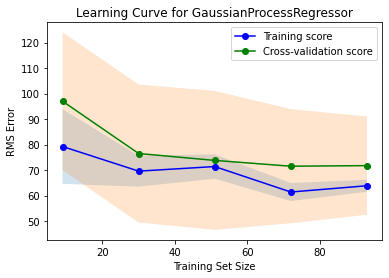

In [25]:
train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

In [26]:
X = X.to_numpy()
y = y.to_numpy()

In [27]:
y_Test=y_Test.to_numpy()

In [28]:
kf=cv

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 108.545835

Root Mean squared error: 60.500545

Root Mean squared error: 51.770180

Root Mean squared error: 94.902777

Root Mean squared error: 76.556923

Root Mean squared error: 65.793267

Root Mean squared error: 40.539653

Root Mean squared error: 60.434323

Root Mean squared error: 84.580696

Root Mean squared error: 74.519825

error COV--->0    0.939242
dtype: float64  error mean --->0    52.201542
Name: mean, dtype: float64  error std --->0    49.029856
Name: std, dtype: float64


# train score

In [29]:
ytestunk=HBM_Train.predict(X)
err=np.zeros(len(ytestunk))

for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    0.954735
dtype: float64  error mean --->0    47.033267
Name: mean, dtype: float64  error std --->0    44.904319
Name: std, dtype: float64
